<a href="https://colab.research.google.com/github/VAMSI-datascience/Advertisement-Click-Through-Rate-prediction/blob/main/Final_Project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
import os
os.environ['KAGGLE_CONFIG_DIR'] = "/content/gdrive/My Drive/Kaggle"

In [ ]:
%cd /content/gdrive/My Drive/Kaggle

/content/gdrive/My Drive/Kaggle


In [ ]:
! pip install kaggle

In [ ]:
! mkdir ~/.kaggle

In [ ]:
! cp kaggle.json ~/.kaggle/

In [ ]:
! chmod 600 ~/.kaggle/kaggle.json

In [ ]:
! kaggle competitions download -c avazu-ctr-prediction -f train.gz

train.gz: Skipping, found more recently modified local copy (use --force to force download)


In [ ]:
! kaggle competitions download -c avazu-ctr-prediction -f test.gz

test.gz: Skipping, found more recently modified local copy (use --force to force download)


In [ ]:
import pandas as pd
df=pd.read_csv('train.gz',header=0, nrows=100000).sample(frac=1)
df.head()
df.shape
df.head()

,id,click,hour,C1,banner_pos,site_id,site_domain,site_category,app_id,app_domain,app_category,device_id,device_ip,device_model,device_type,device_conn_type,C14,C15,C16,C17,C18,C19,C20,C21
92977,6.356848e+18,1,14102100,1005,0,1fbe01fe,f3845767,28905ebd,ecad2386,7801e8d9,07d7df22,a99f214a,75bb1b58,0eb711ec,1,0,15704,320,50,1722,0,35,-1,79
67154,2.733697e+18,0,14102100,1005,0,543a539e,c7ca3108,3e814130,ecad2386,7801e8d9,07d7df22,a99f214a,a98e3a73,d787e91b,1,0,20366,320,50,2333,0,39,-1,157
54008,1.752551e+19,0,14102100,1005,0,85f751fd,c4e18dd6,50e219e0,6415a993,2347f47a,0f2161f8,a99f214a,357608d1,3de05cb4,1,2,15006,320,50,1637,0,161,100046,91
6848,1.095175e+19,0,14102100,1005,0,1fbe01fe,f3845767,28905ebd,ecad2386,7801e8d9,07d7df22,a99f214a,1477504f,5096d134,1,0,15702,320,50,1722,0,35,100084,79
63559,2.230643e+17,0,14102100,1005,0,543a539e,c7ca3108,3e814130,ecad2386,7801e8d9,07d7df22,a99f214a,ac2e0d7c,3223bcfe,1,0,20362,320,50,2333,0,39,-1,157


In [ ]:
df.drop(['id','hour'],axis=1,inplace=True)

As we can see that few columns from site_id to device_model contains categorical along with the numerical values so we can use either label encoding or one-hot encoding.

But here we will particularly use label encoding because doing one-hot encoding we'll end up adding 5000 rows which may lead to curse of dimensionality.

In [ ]:
cat_features=df.select_dtypes(include='object').columns
from sklearn.preprocessing import LabelEncoder
encoded=LabelEncoder()
for features in cat_features:
    df[features]=encoded.fit_transform(df[features].astype(str))
    
df.head()

,click,C1,banner_pos,site_id,site_domain,site_category,app_id,app_domain,app_category,device_id,device_ip,device_model,device_type,device_conn_type,C14,C15,C16,C17,C18,C19,C20,C21
92977,1,1005,0,104,742,2,656,23,0,4865,18505,149,1,0,15704,320,50,1722,0,35,-1,79
67154,0,1005,0,317,605,4,656,23,0,4865,26777,2086,1,0,20366,320,50,2333,0,39,-1,157
54008,0,1005,0,475,595,6,286,6,2,4865,8321,609,1,2,15006,320,50,1637,0,161,100046,91
6848,0,1005,0,104,742,2,656,23,0,4865,3141,776,1,0,15702,320,50,1722,0,35,100084,79
63559,0,1005,0,317,605,4,656,23,0,4865,27169,482,1,0,20362,320,50,2333,0,39,-1,157


In [ ]:
df.describe()

,click,C1,banner_pos,site_id,site_domain,site_category,app_id,app_domain,app_category,device_id,device_ip,device_model,device_type,device_conn_type,C14,C15,C16,C17,C18,C19,C20,C21
count,100000.000000,100000.000000,100000.00000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.00000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000
mean,0.174900,1005.034410,0.19830,341.261050,562.030190,5.833680,600.967380,22.123920,1.155720,4704.125230,20086.63761,1239.913660,1.055730,0.199270,17682.145900,318.333960,56.818920,1964.034380,0.789350,131.734480,37874.227610,88.555670
std,0.379883,1.088741,0.40264,240.054253,203.036194,4.465185,150.486829,6.053525,3.464608,859.050969,11548.13482,686.803684,0.583993,0.635268,3237.735265,11.931939,36.924104,394.962696,1.223761,244.076787,48546.274316,45.482841
min,0.000000,1001.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,375.000000,120.000000,20.000000,112.000000,0.000000,33.000000,-1.000000,13.000000
25%,0.000000,1005.000000,0.00000,104.000000,467.000000,2.000000,656.000000,23.000000,0.000000,4865.000000,10418.00000,614.000000,1.000000,0.000000,15704.000000,320.000000,50.000000,1722.000000,0.000000,35.000000,-1.000000,61.000000
50%,0.000000,1005.000000,0.00000,317.000000,595.000000,4.000000,656.000000,23.000000,0.000000,4865.000000,19790.00000,1286.000000,1.000000,0.000000,17654.000000,320.000000,50.000000,1993.000000,0.000000,35.000000,-1.000000,79.000000
75%,0.000000,1005.000000,0.00000,475.000000,742.000000,6.000000,656.000000,23.000000,0.000000,4865.000000,30051.00000,1852.000000,1.000000,0.000000,20362.000000,320.000000,50.000000,2306.000000,2.000000,39.000000,100083.000000,156.000000
max,1.000000,1010.000000,5.00000,892.000000,779.000000,15.000000,703.000000,54.000000,18.000000,7201.000000,40375.00000,2472.000000,5.000000,5.000000,21705.000000,728.000000,480.000000,2497.000000,3.000000,1835.000000,100248.000000,157.000000


In [ ]:
X=df.drop('click',axis=1)
y=df.click

0    82510
1    17490
Name: click, dtype: int64


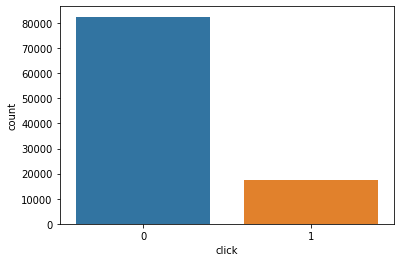

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
sns.countplot(x='click',data=df)
print(df['click'].value_counts())
#clearly we can see that there is class imbalance

1    92597
0     4212
4     2979
5      212
Name: device_type, dtype: int64

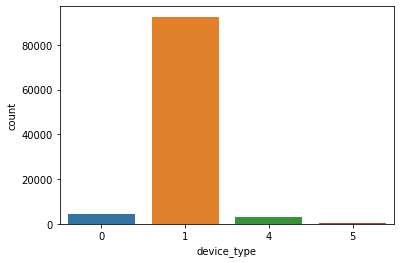

In [ ]:
data=pd.concat([df['click'],df['device_type']],axis=1)
sns.countplot(x='device_type',data=data)
data.loc[:,'device_type'].value_counts()

# We can see that device 1 has the prevalent clicks

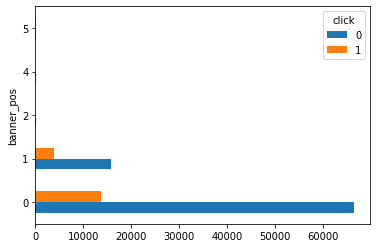

In [ ]:
df.groupby(['banner_pos', 'click']).size().unstack().plot(kind='barh')
# We can also visualize that if the add is displayed at the position 
# 0 there are more number of clicks followed by psoition 1

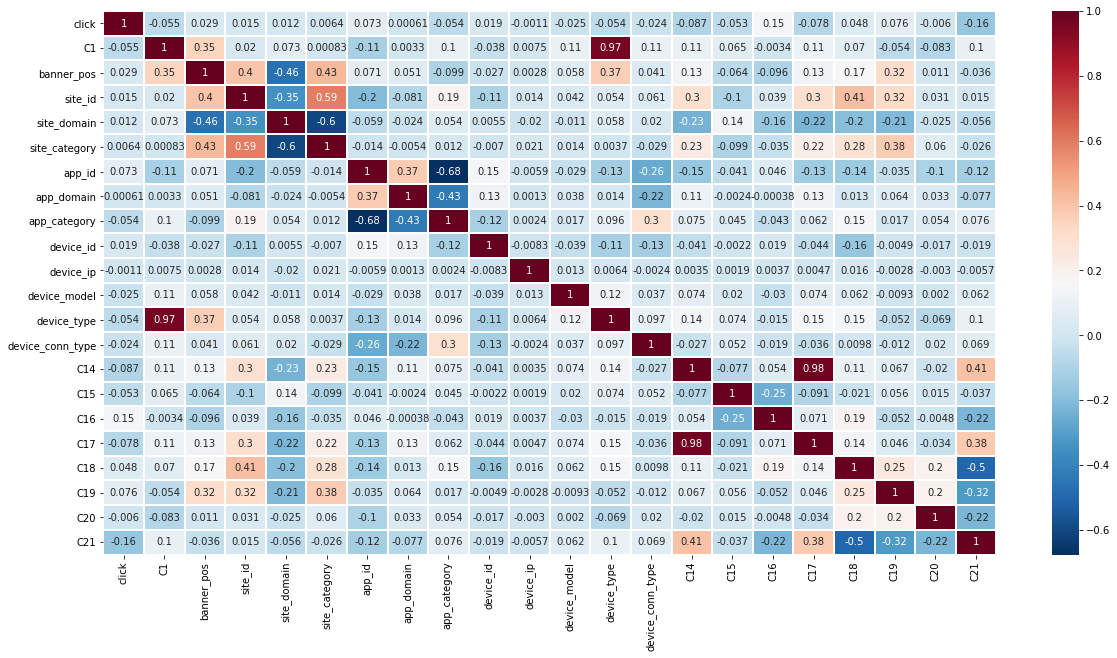

In [ ]:
corr_mat = df.corr(method = 'pearson')
fig,ax = plt.subplots(figsize = (20,10))
sns.heatmap(corr_mat,xticklabels=corr.columns,yticklabels=corr.columns,cmap='RdBu_r',annot=True,linewidth=1,ax=ax)

In [ ]:

threshold=0.8
# find and remove correlated features
def correlation(dataset, threshold):
    col_corr = set()  # Set of all the names of correlated columns
    corr_matrix = dataset.corr()
    for i in range(len(corr_matrix.columns)):
        for j in range(i):
            if abs(corr_matrix.iloc[i, j]) > threshold: # we are interested in absolute coeff value
                colname = corr_matrix.columns[i]  # getting the name of column
                col_corr.add(colname)
    return col_corr

In [ ]:
correlation(df,threshold)

{'C17', 'device_type'}


The heatmap allows us to easily see that:

the highest positive correlation (red squares) is between C1 and  device_type and also C14 and C17 are also highly positive correlation. 

We also  have negatively correlated variables (blue squares) —  app_id and app_category.
the variables C18 and C21 are also negatively correlated to eachother.

We can see that no feature is highly correlated with the target varibale meaning that we need to try all the features and see which features best fit for our model.




In [ ]:
from sklearn.ensemble import ExtraTreesClassifier
import matplotlib.pyplot as plt
model=ExtraTreesClassifier()
model.fit(X,y)

ExtraTreesClassifier(bootstrap=False, ccp_alpha=0.0, class_weight=None,
                     criterion='gini', max_depth=None, max_features='auto',
                     max_leaf_nodes=None, max_samples=None,
                     min_impurity_decrease=0.0, min_impurity_split=None,
                     min_samples_leaf=1, min_samples_split=2,
                     min_weight_fraction_leaf=0.0, n_estimators=100,
                     n_jobs=None, oob_score=False, random_state=None, verbose=0,
                     warm_start=False)

In [ ]:
print(model.feature_importances_)

[0.00224382 0.00588405 0.0248296  0.02180933 0.00896494 0.01219722
 0.00431865 0.00499804 0.02558968 0.46763909 0.2294734  0.00285105
 0.00611944 0.07713613 0.0035312  0.01136876 0.01298654 0.0166918
 0.01539449 0.02627472 0.01969805]


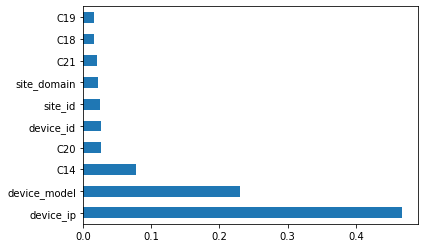

In [ ]:
ranked_features=pd.Series(model.feature_importances_,index=X.columns)
ranked_features.nlargest(10).plot(kind='barh')
plt.show()

We have used extra Tree Classifier in order to select the important features of our data. We can see that device_ip and device_model are important features according to extraTree classifier with respect to our target variable.

In [ ]:
from sklearn.model_selection import train_test_split
X_train,X_test,y_train,y_test=train_test_split(X,y,test_size=0.2,random_state=5)

In [ ]:
# We have used standard scaling in order scale down all the features
from sklearn.preprocessing import StandardScaler
sc=StandardScaler()
X_train=sc.fit_transform(X_train)
X_test=sc.transform(X_test)

### Model training without hyperparameters

### Here we are interested in roc_auc score rather than accuracy because as the dataset is imbalanced we always get good accuarcy so here we will consider the precision-recall score from confusion matrix and roc_auc score in order to judge our model

In [ ]:
 from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score
from sklearn.metrics import roc_auc_score
from sklearn.metrics import classification_report

model = DecisionTreeClassifier()
model.fit(X_train,y_train)
y_predict=model.predict(X_test)
print(classification_report(y_test,y_predict))
pros=model.predict_proba(X_test)[:, 1]
print('The roc-auc score for Decision Tree is:',roc_auc_score(y_test,pros))
print('--------------------------------------------->')

model1 = LogisticRegression()
model1.fit(X_train,y_train)
y_predict=model1.predict(X_test)
print(classification_report(y_test,y_predict))
pros=model1.predict_proba(X_test)[:, 1]
print('The roc-auc score for Logistic Regression is:',roc_auc_score(y_test,pros))
print('--------------------------------------------->')

model2 = RandomForestClassifier()
model2.fit(X_train,y_train)
y_predict=model2.predict(X_test)
print(classification_report(y_test,y_predict))
pros=model2.predict_proba(X_test)[:, 1]
print('The roc-auc score Random Forest is:',roc_auc_score(y_test,pros))
print('--------------------------------------------->')


model4 = KNeighborsClassifier()
model4.fit(X_train,y_train)
y_predict=model4.predict(X_test)
print(classification_report(y_test,y_predict))
pros=model4.predict_proba(X_test)[:, 1]
print('The roc-auc score KNN is:',roc_auc_score(y_test,pros))
print('--------------------------------------------->')

#model5 = XGBClassifier()
#model5.fit(X_train,y_train)
#y_predict=model5.predict(X_test)
##print(classification_report(y_test,y_predict))
#pros=model5.predict_proba(X_test)[:, 1]
#print('The roc-auc score for XGboost is:',roc_auc_score(y_test,pros))
#print('--------------------------------------------->')




              precision    recall  f1-score   support

           0       0.86      0.88      0.87     16509
           1       0.35      0.31      0.33      3491

    accuracy                           0.78     20000
   macro avg       0.60      0.59      0.60     20000
weighted avg       0.77      0.78      0.77     20000

The roc-auc score for Decision Tree is: 0.5936054097832526
--------------------------------------------->
              precision    recall  f1-score   support

           0       0.83      1.00      0.90     16509
           1       0.38      0.01      0.02      3491

    accuracy                           0.82     20000
   macro avg       0.60      0.50      0.46     20000
weighted avg       0.75      0.82      0.75     20000

The roc-auc score for Logistic Regression is: 0.6584202944848239
--------------------------------------------->
              precision    recall  f1-score   support

           0       0.85      0.92      0.88     16509
           1       

###From the above results we can say that the precision and recall score for class 1 is very less meaning that our model will predict even if the person clicks the add i.e 1 it will predict as 0 for all the cases.

###This is mainly because of the data imbalance.




In [ ]:
from sklearn.model_selection import GridSearchCV,RandomizedSearchCV
from sklearn.model_selection import ShuffleSplit

In [ ]:
#XGBoost Classifier

import xgboost
classifier=xgboost.XGBClassifier()
#from XGboost import XGboostClassifier

n_estimators = [100, 300, 400,500]
max_depth = [2, 3, 5, 10, 15]
booster=['gbtree']
learning_rate=[0.05,0.1,0.15,0.20]
min_child_weight=[1,2,3,4]

# Define the grid of hyperparameters to search
hyperparameter_grid = {
    'n_estimators': n_estimators,
    'max_depth':max_depth,
    'learning_rate':learning_rate,
    'min_child_weight':min_child_weight,
    'booster':booster
    }

random_cv = RandomizedSearchCV(estimator=classifier,
            param_distributions=hyperparameter_grid,
            cv=5, n_iter=50,n_jobs = 5,
            verbose = 5, 
            return_train_score = True,
            random_state=42)


random_cv.fit(X_train,y_train)

Fitting 5 folds for each of 50 candidates, totalling 250 fits


[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Done   8 tasks      | elapsed:  5.8min
[Parallel(n_jobs=5)]: Done  62 tasks      | elapsed: 21.2min
[Parallel(n_jobs=5)]: Done 152 tasks      | elapsed: 63.9min
[Parallel(n_jobs=5)]: Done 250 out of 250 | elapsed: 92.4min finished


RandomizedSearchCV(cv=5, error_score=nan,
                   estimator=XGBClassifier(base_score=0.5, booster='gbtree',
                                           colsample_bylevel=1,
                                           colsample_bynode=1,
                                           colsample_bytree=1, gamma=0,
                                           learning_rate=0.1, max_delta_step=0,
                                           max_depth=3, min_child_weight=1,
                                           missing=None, n_estimators=100,
                                           n_jobs=1, nthread=None,
                                           objective='binary:logistic',
                                           random_state=0, reg_alpha=0,
                                           reg_lambda=1, sc...1,
                                           seed=None, silent=None, subsample=1,
                                           verbosity=1),
                   iid='deprecated', n

In [ ]:
print('the parameters are',random_cv.best_params_)
random_cv.best_score_


the parameters are {'n_estimators': 400, 'min_child_weight': 1, 'max_depth': 15, 'learning_rate': 0.15, 'booster': 'gbtree'}


0.8582671696049285

In [ ]:
from xgboost import XGBClassifier
from sklearn.metrics import classification_report
from sklearn.metrics import roc_auc_score
model5 = XGBClassifier(n_estimators = 400, min_child_weight = 1, max_depth= 15, learning_rate= 0.15, booster= 'gbtree')
model5.fit(X_train,y_train)
y_predict=model5.predict(X_test)
print(classification_report(y_test,y_predict))
pros=model5.predict_proba(X_test)[:, 1]
print('The roc-auc score for XGboost after hyperparameter tuning is:',roc_auc_score(y_test,pros))

              precision    recall  f1-score   support

           0       0.85      0.95      0.90     16509
           1       0.47      0.21      0.29      3491

    accuracy                           0.82     20000
   macro avg       0.66      0.58      0.59     20000
weighted avg       0.78      0.82      0.79     20000

The roc-auc score for XGboost after hyperparameter tuning is: 0.7332708672972126


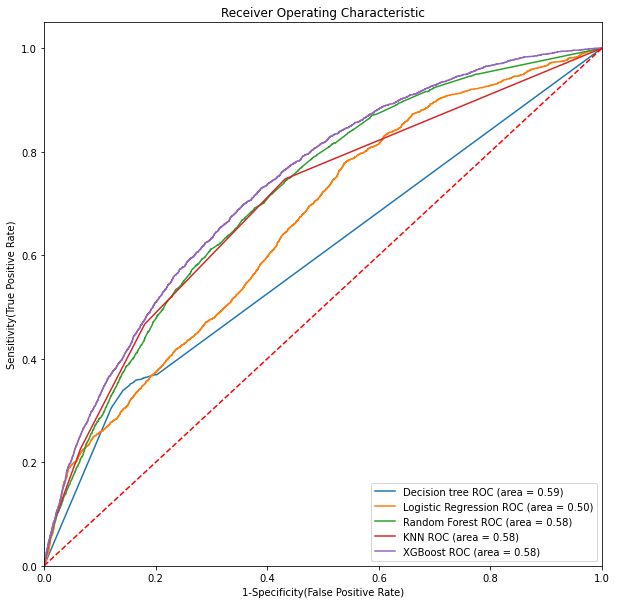

In [ ]:
from sklearn import metrics
import matplotlib.pyplot as plt

plt.figure(figsize=[10,10])

# Add the models to the list that you want to view on the ROC plot
models = [
{
    'label': 'Decision tree',
    'model': model,
},
{
    'label': 'Logistic Regression',
    'model': model1,
},
{
    'label': 'Random Forest',
    'model': model2,
},
{
    'label': 'KNN',
    'model': model4,
},
{
    'label': 'XGBoost',
    'model': model5,
}
]

# Below for loop iterates through your models list
for m in models:
    model = m['model'] # select the model
    model.fit(X_train, y_train) # train the model
    y_pred=model.predict(X_test) # predict the test data
# Compute False postive rate, and True positive rate
    fpr, tpr, thresholds = metrics.roc_curve(y_test, model.predict_proba(X_test)[:,1])
# Calculate Area under the curve to display on the plot
    auc = metrics.roc_auc_score(y_test,model.predict(X_test))
# Now, plot the computed values
    plt.plot(fpr, tpr, label='%s ROC (area = %0.2f)' % (m['label'], auc))
# Custom settings for the plot 
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('1-Specificity(False Positive Rate)')
plt.ylabel('Sensitivity(True Positive Rate)')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()   # Display


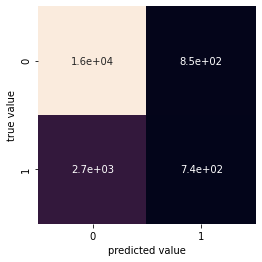

In [ ]:
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

mat = confusion_matrix(y_test, y_predict)

sns.heatmap(mat, square=True, annot=True, cbar=False)
plt.xlabel('predicted value')
plt.ylabel('true value');

In [ ]:
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

mat = confusion_matrix(y_test, y_predict)
print(mat)

#sns.heatmap(mat, square=True, annot=True, cbar=False)
#plt.xlabel('predicted value')
#plt.ylabel('true value');

[[15659   850]
 [ 2749   742]]


###From the above we can clearly see that even after the hyperparameter tunning the precision and recall for the class 1 is has improved a bit but it is not ideal for our prediction

###This is mainly because of the data imbalance.

###Now let us implement SMOTE method in order to handle the data imbalance and then check how the precision and recall varies.

#Now we will implement using SMOTE





0    82510
1    17490
Name: click, dtype: int64


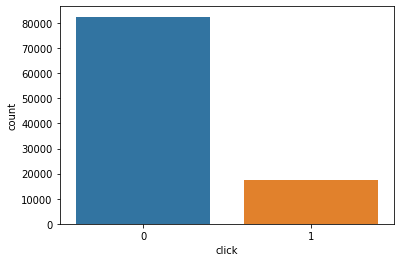

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
sns.countplot(x='click',data=df)
print(df['click'].value_counts())
#clearly we can see that there is class imbalance

In [ ]:
from imblearn.over_sampling import SMOTE
sm=SMOTE(random_state=42)
X_sample,y_sample=sm.fit_resample(X,y)

print(f'''Shape of X before SMOTE: {X.shape}
Shape of X after SMOTE: {X_sample.shape}''')

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


Shape of X before SMOTE: (100000, 21)
Shape of X after SMOTE: (165020, 21)


###Now after using smote technique for balancing the dataset we can clearly see the shape of our sampled data that it has increased meaning that it has done upsmapling of the minority class i.e class 1 in order for our model to predict well.

In [ ]:
from sklearn.ensemble import ExtraTreesClassifier
import matplotlib.pyplot as plt
model=model5
model.fit(X_sample,y_sample)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0,
              learning_rate=0.15, max_delta_step=0, max_depth=15,
              min_child_weight=1, missing=None, n_estimators=400, n_jobs=1,
              nthread=None, objective='binary:logistic', random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
              silent=None, subsample=1, verbosity=1)

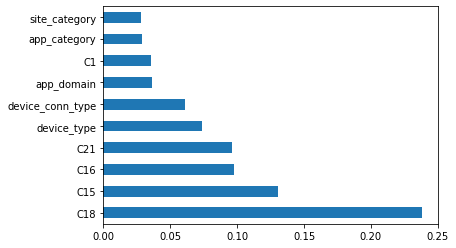

In [ ]:
ranked_features=pd.Series(model.feature_importances_,index=X.columns)
ranked_features.nlargest(10).plot(kind='barh')
plt.show()

We can see that

In [ ]:
from sklearn.model_selection import train_test_split
X_train,X_test,y_train,y_test=train_test_split(X_sample,y_sample,test_size=0.2,random_state=5)

In [ ]:
from sklearn.preprocessing import StandardScaler
sc=StandardScaler()
X_train=sc.fit_transform(X_train)
X_test=sc.transform(X_test)

In [ ]:
# Model training without hyperparameters

from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score
from sklearn.metrics import roc_auc_score
from sklearn.metrics import classification_report

model = DecisionTreeClassifier()
model.fit(X_train,y_train)
y_predict=model.predict(X_test)
print(classification_report(y_test,y_predict))
pros=model.predict_proba(X_test)[:, 1]
print('The roc-auc score for Decision Tree is:',roc_auc_score(y_test,pros))
print('--------------------------------------------->')

model1 = LogisticRegression()
model1.fit(X_train,y_train)
y_predict=model1.predict(X_test)
print(classification_report(y_test,y_predict))
pros=model1.predict_proba(X_test)[:, 1]
print('The roc-auc score for Logistic Regression is:',roc_auc_score(y_test,pros))
print('--------------------------------------------->')

model2 = RandomForestClassifier()
model2.fit(X_train,y_train)
y_predict=model2.predict(X_test)
print(classification_report(y_test,y_predict))
pros=model2.predict_proba(X_test)[:, 1]
print('The roc-auc score Random Forest is:',roc_auc_score(y_test,pros))
print('--------------------------------------------->')


model4 = KNeighborsClassifier()
model4.fit(X_train,y_train)
y_predict=model4.predict(X_test)
print(classification_report(y_test,y_predict))
pros=model4.predict_proba(X_test)[:, 1]
print('The roc-auc score KNN is:',roc_auc_score(y_test,pros))
print('--------------------------------------------->')

model5 = XGBClassifier()
model5.fit(X_train,y_train)
y_predict=model5.predict(X_test)
print(classification_report(y_test,y_predict))
pros=model5.predict_proba(X_test)[:, 1]
print('The roc-auc score for XGboost is:',roc_auc_score(y_test,pros))
print('--------------------------------------------->')




              precision    recall  f1-score   support

           0       0.83      0.84      0.83     16470
           1       0.84      0.83      0.83     16534

    accuracy                           0.83     33004
   macro avg       0.83      0.83      0.83     33004
weighted avg       0.83      0.83      0.83     33004

The roc-auc score for Decision Tree is: 0.841460767233591
--------------------------------------------->
              precision    recall  f1-score   support

           0       0.68      0.50      0.57     16470
           1       0.60      0.76      0.67     16534

    accuracy                           0.63     33004
   macro avg       0.64      0.63      0.62     33004
weighted avg       0.64      0.63      0.62     33004

The roc-auc score for Logistic Regression is: 0.6709665659964794
--------------------------------------------->
              precision    recall  f1-score   support

           0       0.84      0.84      0.84     16470
           1       0

We will use the XGBoost hyperparameters that we got previously using GridsearchCV

In [ ]:
from xgboost import XGBClassifier
model5 = XGBClassifier(n_estimators = 400, min_child_weight = 1, max_depth= 15, learning_rate= 0.15, booster= 'gbtree')
model5.fit(X_train,y_train)
y_predict=model5.predict(X_test)
print(classification_report(y_test,y_predict))
pros=model5.predict_proba(X_test)[:, 1]
print('The roc-auc score for XGboost after hyperparameter tuning is:',roc_auc_score(y_test,pros))

              precision    recall  f1-score   support

           0       0.85      0.89      0.87     16534
           1       0.88      0.85      0.86     16470

    accuracy                           0.87     33004
   macro avg       0.87      0.87      0.87     33004
weighted avg       0.87      0.87      0.87     33004

The roc-auc score for XGboost after hyperparameter tuning is: 0.9369600104261617


We can see here

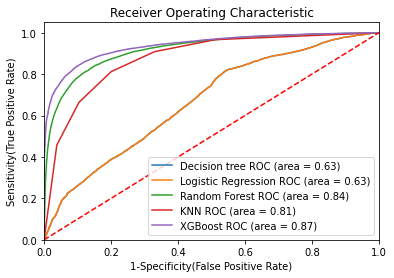

In [ ]:
from sklearn import metrics
import matplotlib.pyplot as plt

plt.figure(figsize=[10,10])

# Add the models to the list that you want to view on the ROC plot
models = [
{
    'label': 'Decision tree',
    'model': model,
},
{
    'label': 'Logistic Regression',
    'model': model1,
},
{
    'label': 'Random Forest',
    'model': model2,
},
{
    'label': 'KNN',
    'model': model4,
},
{
    'label': 'XGBoost',
    'model': model5,
}
]

# Below for loop iterates through your models list
for m in models:
    model = m['model'] # select the model
    model.fit(X_train, y_train) # train the model
    y_pred=model.predict(X_test) # predict the test data
# Compute False postive rate, and True positive rate
    fpr, tpr, thresholds = metrics.roc_curve(y_test, model.predict_proba(X_test)[:,1])
# Calculate Area under the curve to display on the plot
    auc = metrics.roc_auc_score(y_test,model.predict(X_test))
# Now, plot the computed values
    plt.plot(fpr, tpr, label='%s ROC (area = %0.2f)' % (m['label'], auc))
# Custom settings for the plot 
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('1-Specificity(False Positive Rate)')
plt.ylabel('Sensitivity(True Positive Rate)')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()   # Display


###Now we will do some predictions in order to understand how our model performs

In [ ]:
def predict_ctr(C1, banner_pos, site_id, site_domain, site_category, app_id, app_domain, app_category, device_id, device_ip, device_model,
       device_type, device_conn_type, C14, C15, C16, C17, C18,
       C19, C20, C21):
    C1 = int(C1)
    banner_pos=int(banner_pos)
    site_id=int(site_id)
    site_domain=int(site_domain)
    site_category=int(site_category)
    app_id=int(app_id)
    app_domain=int(app_domain)
    app_category=int(app_category)
    device_id=int(device_id)
    device_ip=int(device_ip)
    device_model=int(device_model)
    device_type=int(device_type)
    device_conn_type=int(device_conn_type)
    C14=int(C14)
    C15=int(C15)
    C16=int(C16)
    C17=int(C17)
    C18=int(C18)
    C19=int(C19)
    C20=int(C20)
    C21=int(C21)

    x = [[C1, banner_pos, site_id, site_domain, site_category, app_id, app_domain, app_category, device_id, device_ip, device_model,
       device_type, device_conn_type, C14, C15, C16, C17, C18,
       C19, C20, C21]]
    x = sc.transform(x)

    return model5.predict(x)

In [ ]:
prediction = predict_ctr(1005, 2, 500, 300, 10 , 546 ,19, 0,5952,152,622,1,0,15704,320,50,1722,3,35,-1,79)[0]
if prediction:
  print('Advertisemnt is clicked.')
else:
  print("Advertisement is not clicked!!.")

Advertisemnt is clicked.


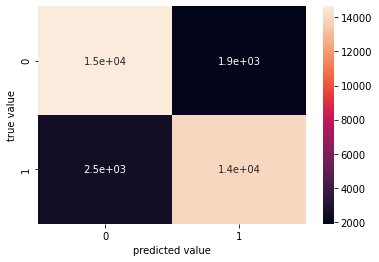

In [ ]:
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt

mat = confusion_matrix(y_test, y_predict)

sns.heatmap(mat, annot=True)
plt.xlabel('predicted value')
plt.ylabel('true value');

In [ ]:
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt

mat = confusion_matrix(y_test, y_predict)
print(mat)

#3sns.heatmap(mat, square=True, annot=True, cbar=False)
#plt.xlabel('predicted value')
#plt.ylabel('true value');

[[14650  1884]
 [ 2514 13956]]
